<a href="https://colab.research.google.com/github/nlei1/nlp-notebooks/blob/main/biowordvec_INTERSECTed_with_patient_ttexts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd 
import os
import zipfile
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec 
import seaborn as sns
import matplotlib.pyplot as pyplot
from nltk.tokenize import RegexpTokenizer
%matplotlib inline

In [2]:
!wget -P /root/input/ -c 'https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'

--2022-07-30 00:52:38--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 130.14.250.12, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451441787 (13G) [application/octet-stream]
Saving to: ‘/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin’

BioWordVec_PubMed_M 100%[===================>]  12.53G  43.9MB/s    in 4m 49s  

2022-07-30 00:57:27 (44.4 MB/s) - ‘/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin’ saved [13451441787/13451441787]



In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(
     '/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary=True,
      limit=int(2E6)
)

In [4]:
url1 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/noi.csv'
drugs = pd.read_csv(url1, error_bad_lines=False)
url2 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/data.csv'
df = pd.read_csv(url2, error_bad_lines=False)
url3 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/reddit_entries2.csv'
forum_posts = pd.read_csv(url3, error_bad_lines=False, names=["Message"])


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
import requests
txt_url = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/mtsamples_corpus.txt'

req = requests.get(txt_url)
req = (req.text).lower()

In [7]:
# sentences = forum_posts.Message.astype('str').tolist()
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenized = tokenizer.tokenize(req)
sentences_tokenized

['A',
 '23',
 'year',
 'old',
 'white',
 'female',
 'presents',
 'with',
 'complaint',
 'of',
 'allergies',
 'SUBJECTIVE',
 'This',
 '23',
 'year',
 'old',
 'white',
 'female',
 'presents',
 'with',
 'complaint',
 'of',
 'allergies',
 'She',
 'used',
 'to',
 'have',
 'allergies',
 'when',
 'she',
 'lived',
 'in',
 'Seattle',
 'but',
 'she',
 'thinks',
 'they',
 'are',
 'worse',
 'here',
 'In',
 'the',
 'past',
 'she',
 'has',
 'tried',
 'Claritin',
 'and',
 'Zyrtec',
 'Both',
 'worked',
 'for',
 'short',
 'time',
 'but',
 'then',
 'seemed',
 'to',
 'lose',
 'effectiveness',
 'She',
 'has',
 'used',
 'Allegra',
 'also',
 'She',
 'used',
 'that',
 'last',
 'summer',
 'and',
 'she',
 'began',
 'using',
 'it',
 'again',
 'two',
 'weeks',
 'ago',
 'It',
 'does',
 'not',
 'appear',
 'to',
 'be',
 'working',
 'very',
 'well',
 'She',
 'has',
 'used',
 'over',
 'the',
 'counter',
 'sprays',
 'but',
 'no',
 'prescription',
 'nasal',
 'sprays',
 'She',
 'does',
 'have',
 'asthma',
 'but',
 'does

In [8]:
model_2 = Word2Vec(size=200, min_count=1)
model_2.build_vocab(sentences_tokenized)
total_examples = model_2.corpus_count
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format('/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)
model_2.train(sentences_tokenized, total_examples=total_examples, epochs=5)

(46972194, 47668965)

In [9]:
url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
df = pd.read_csv(url, header=None, error_bad_lines=False)
insomnia_drug_names = df[0].tolist()
ind_dct = {k: v for v, k in enumerate(insomnia_drug_names)}

def get_words(drug_name):
  return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

def get_embeddings(words_lst):
  # takes in a name and returns a lst of embeddings of drug and its related words
  embeddings = []
  for item in words_lst:
    embeddings.append(model[item])
  return embeddings

def get_pca(embeddings, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(embeddings)
  post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
  return post_pca

def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
  tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
  tsne_result = tsne.fit_transform(embeddings)
  post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
  return post_tsne

def plot_with_labels(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  title_str = drug_name + (": PCA" if pca else ": TSNE")
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_insomnia_drugs():
  for drug in insomnia_drug_names:
    plot_with_labels(drug)
    plot_with_labels(drug, False)

def get_similarity_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

def get_effects_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug, 'effects'], negative=['medication'], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

def forms_of_words_analysis():
  forms_of_words_url = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/forms-of-words.csv'
  forms_of_words_df = pd.read_csv(forms_of_words_url, header=None, error_bad_lines=False)
  word_lst = []
  for index, row in forms_of_words_df.iterrows():
    word_lst += (row.dropna()).tolist()
  new_lst = []
  for thing in word_lst:
    if thing in model.wv.vocab:
      new_lst.append(thing)
  embeddings_lst = get_embeddings(new_lst)
  post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='TSNE')
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)
  post_reduction = get_pca(embeddings_lst, n_components=2)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='PCA')
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


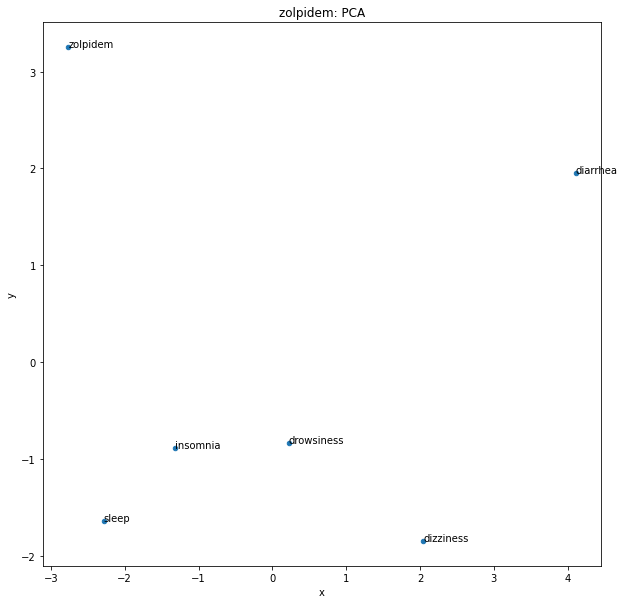

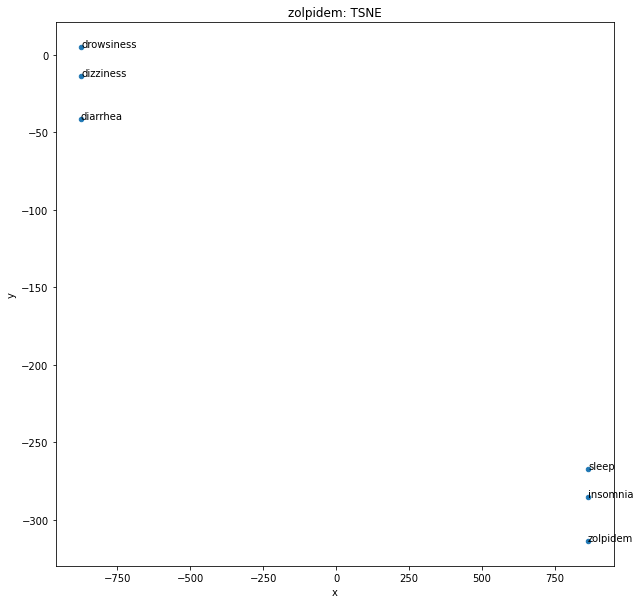

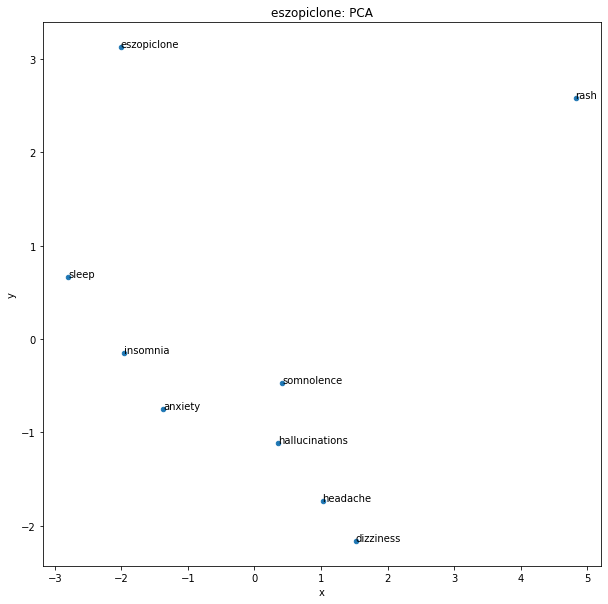

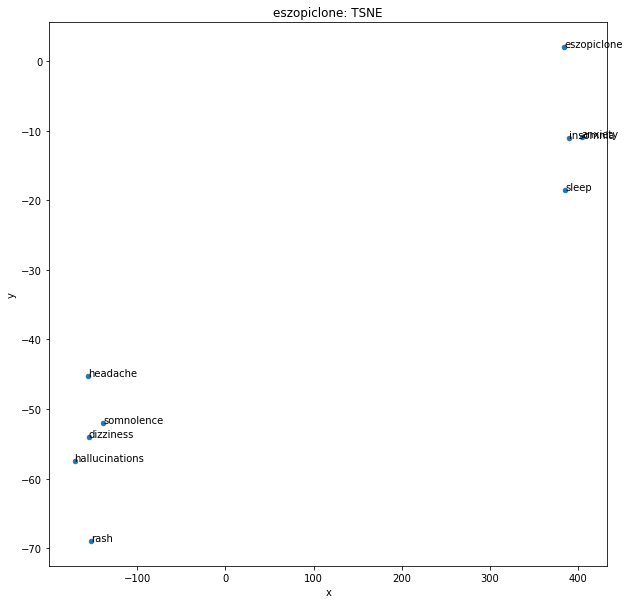

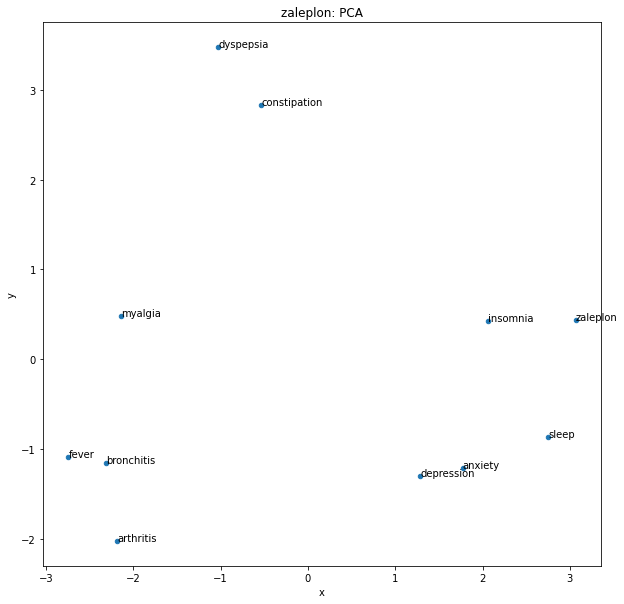

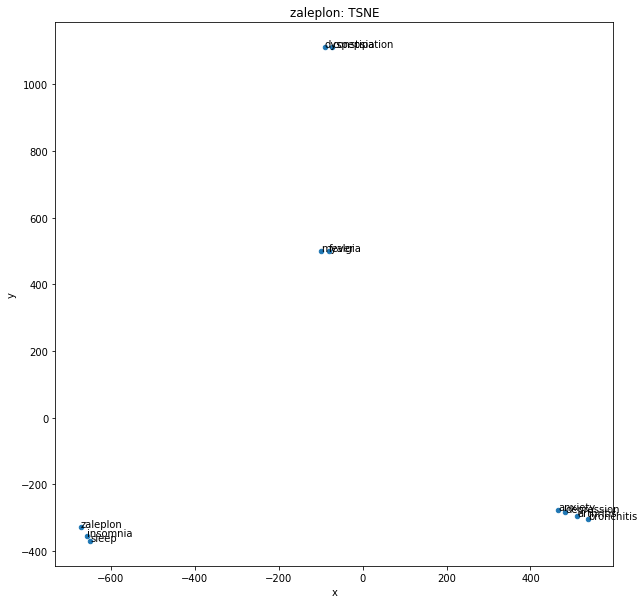

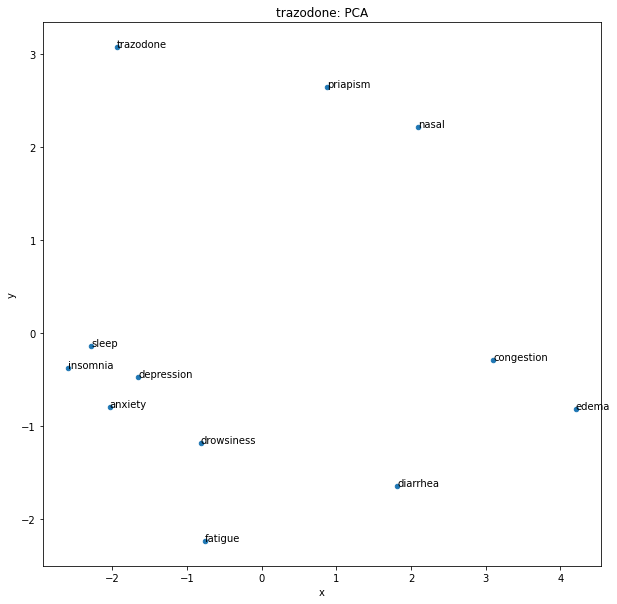

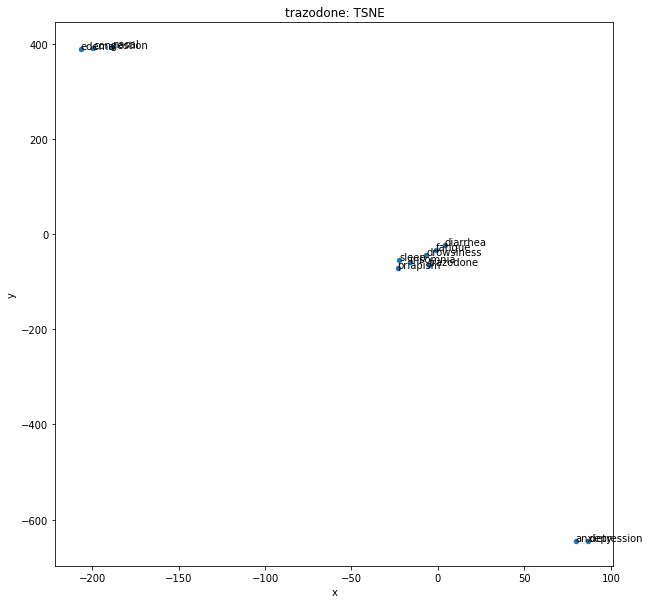

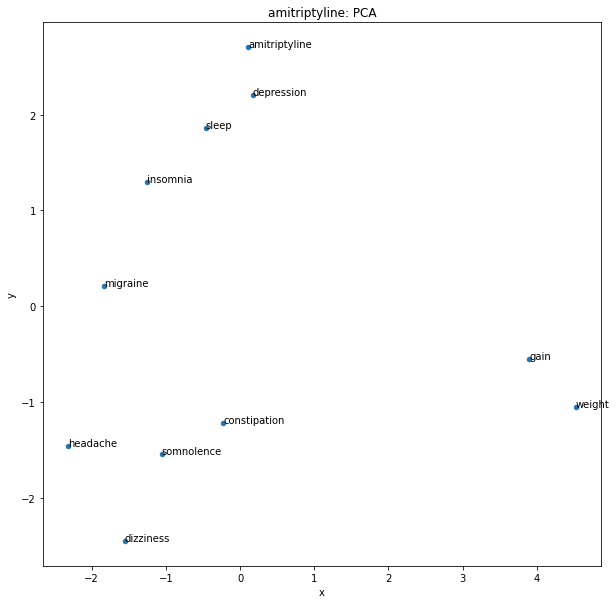

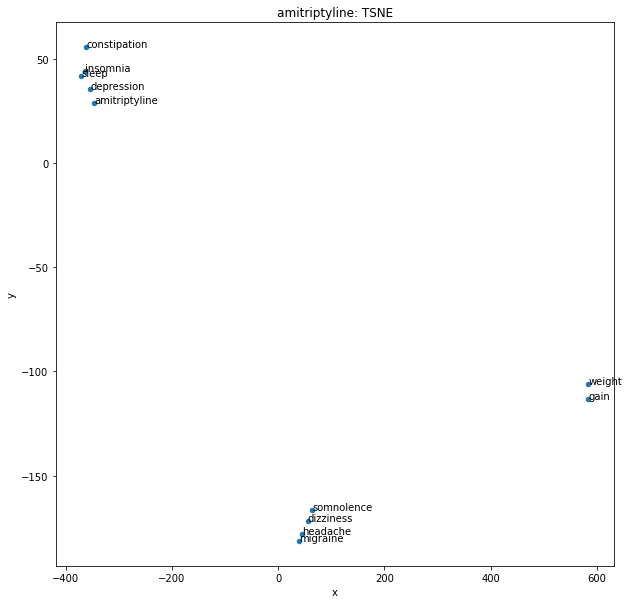

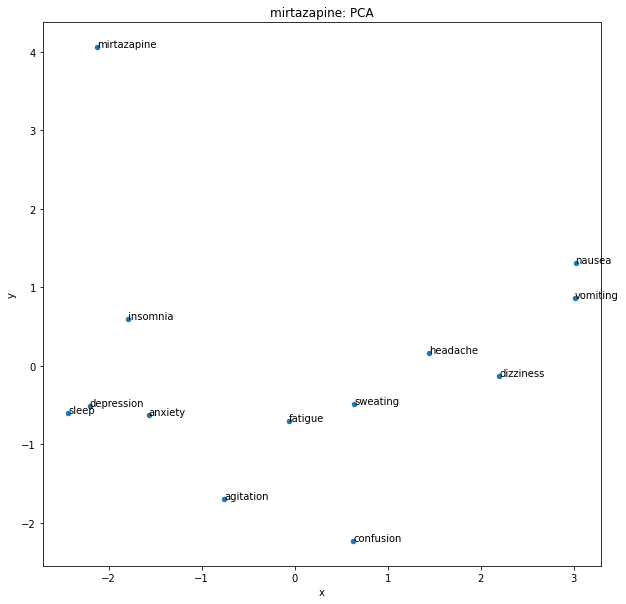

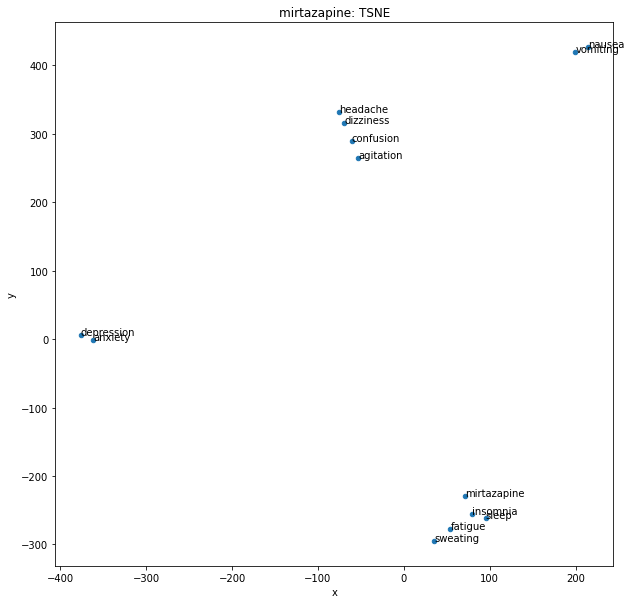

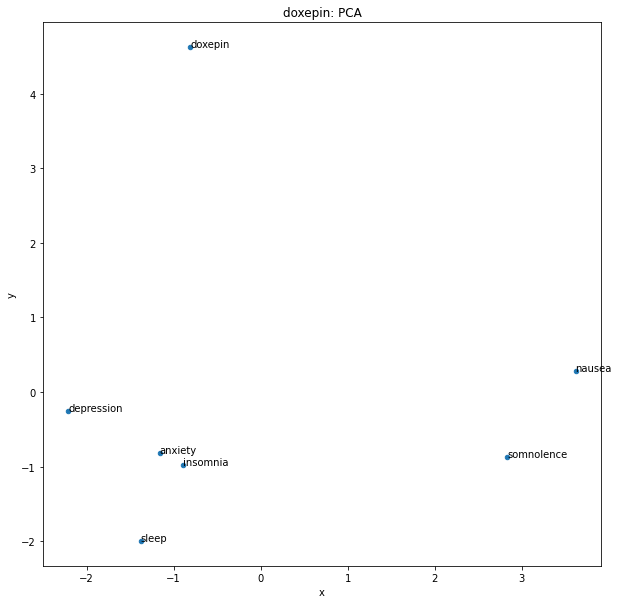

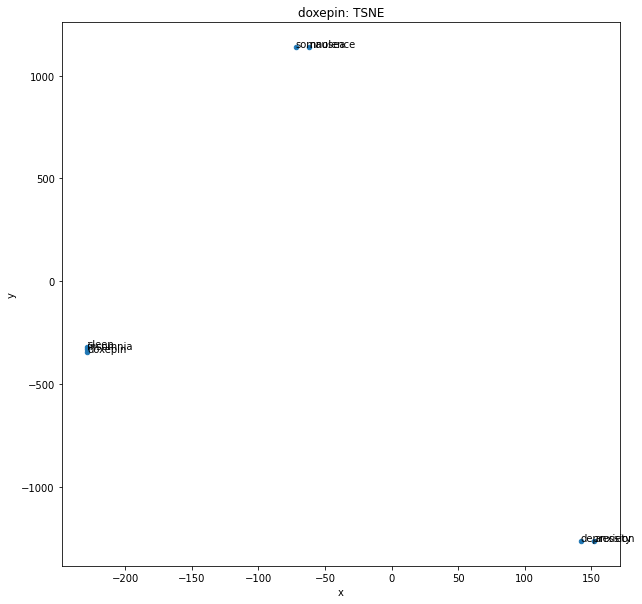

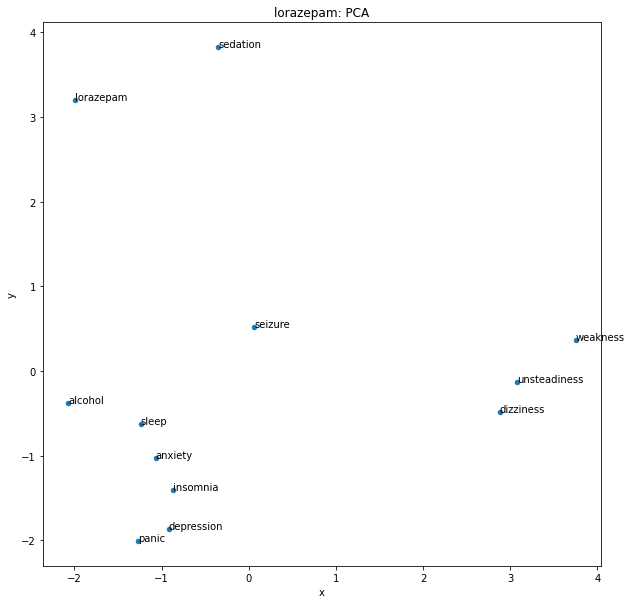

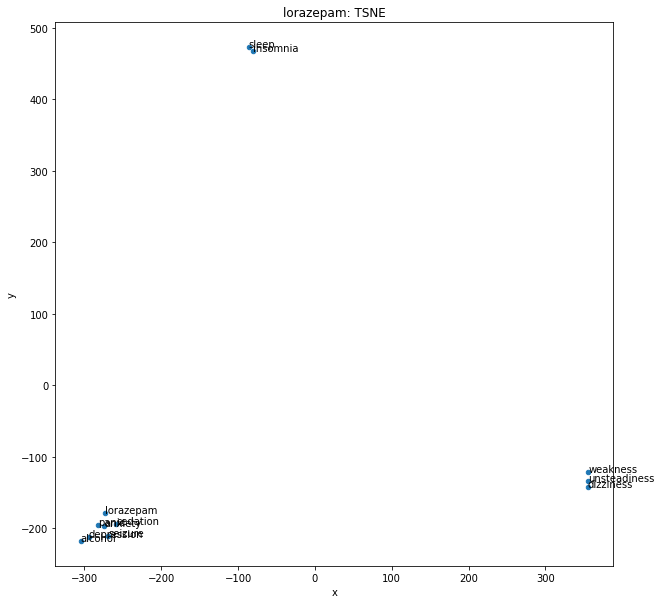

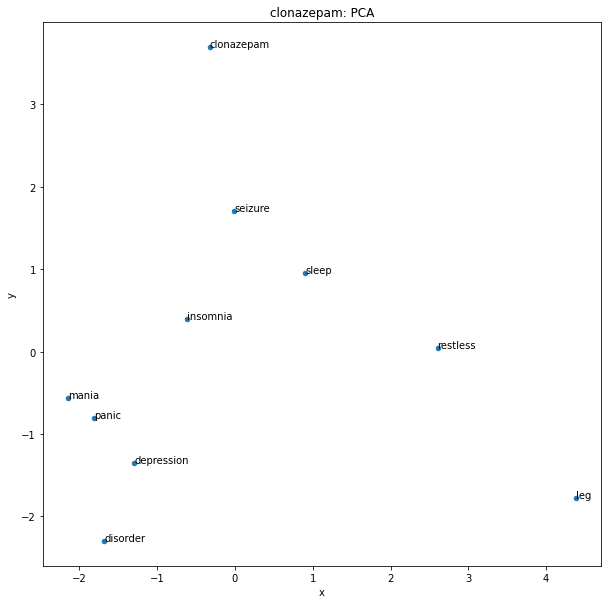

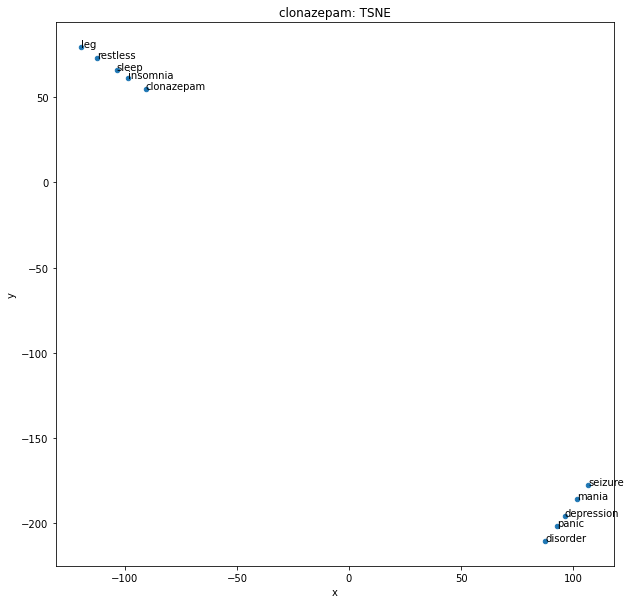

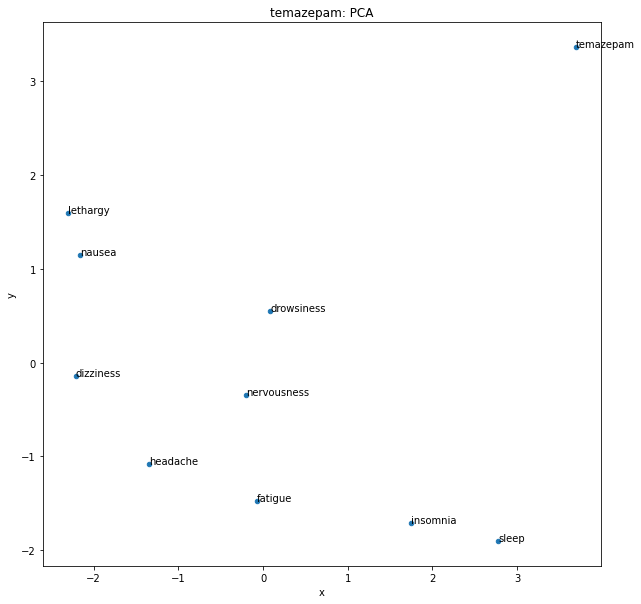

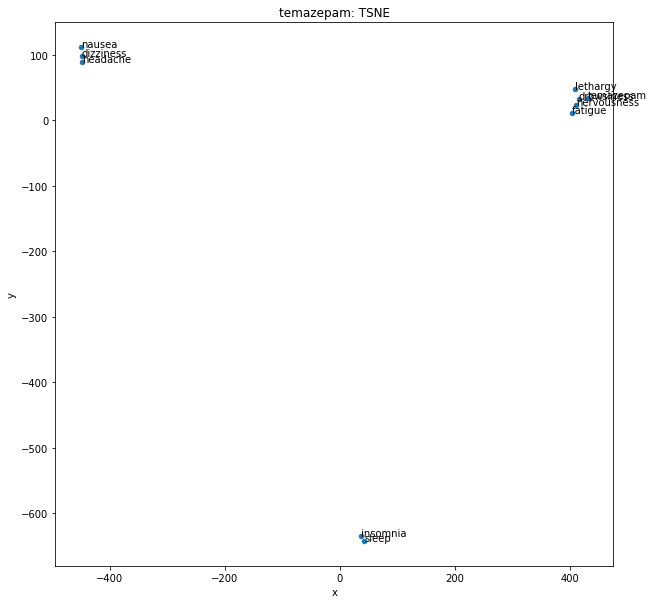

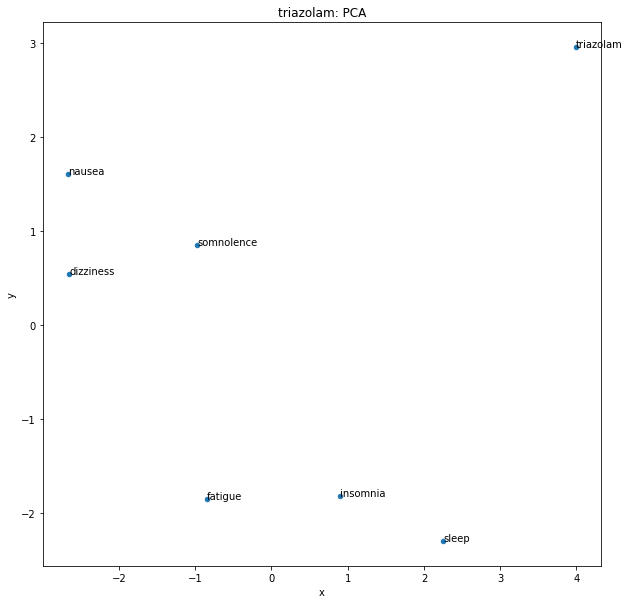

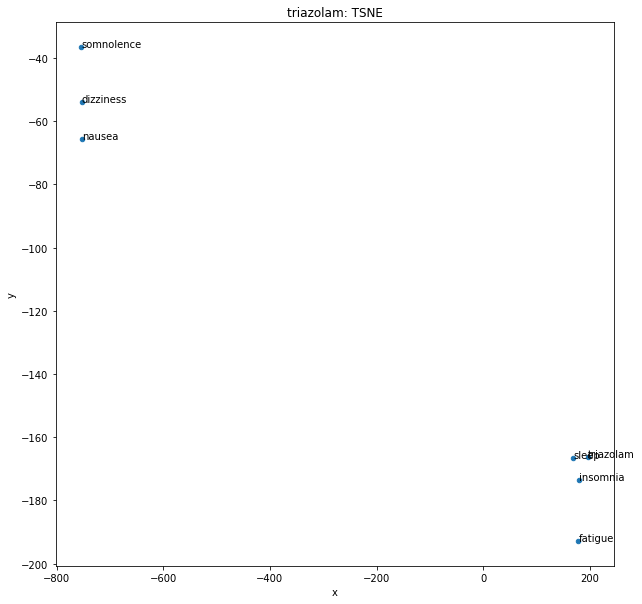

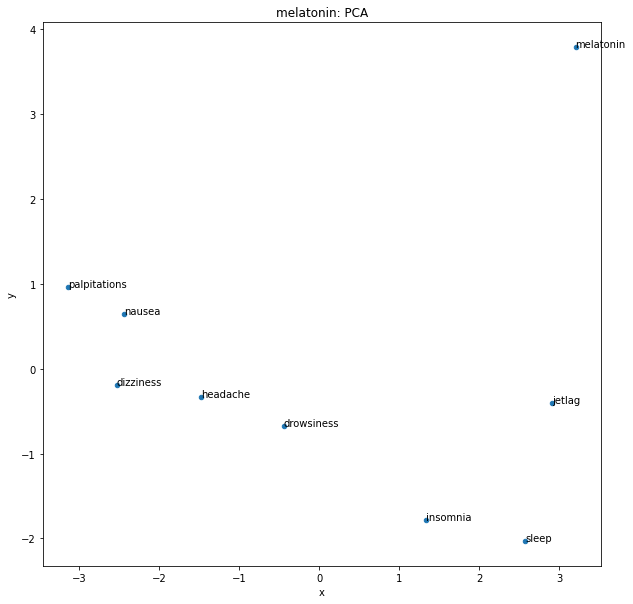

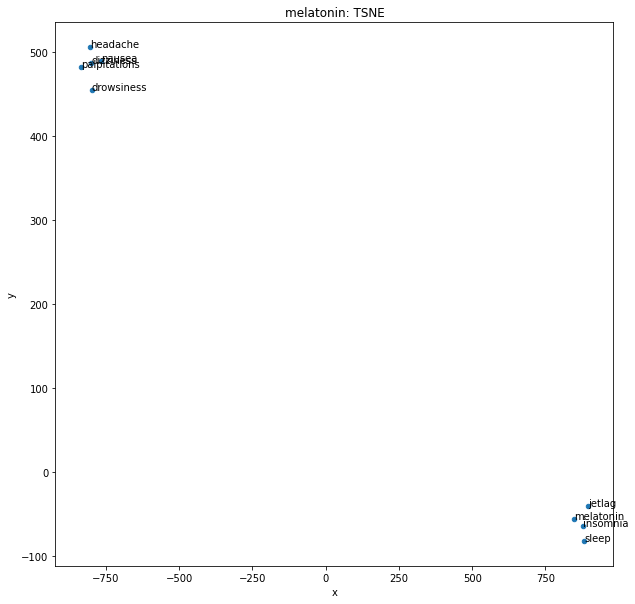

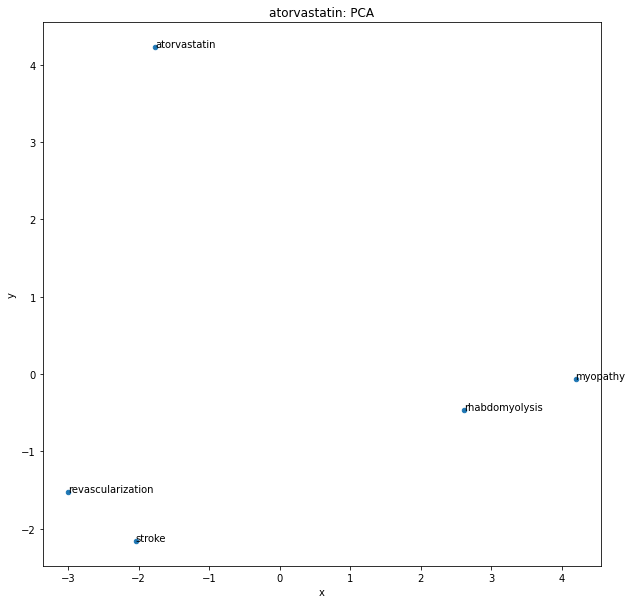

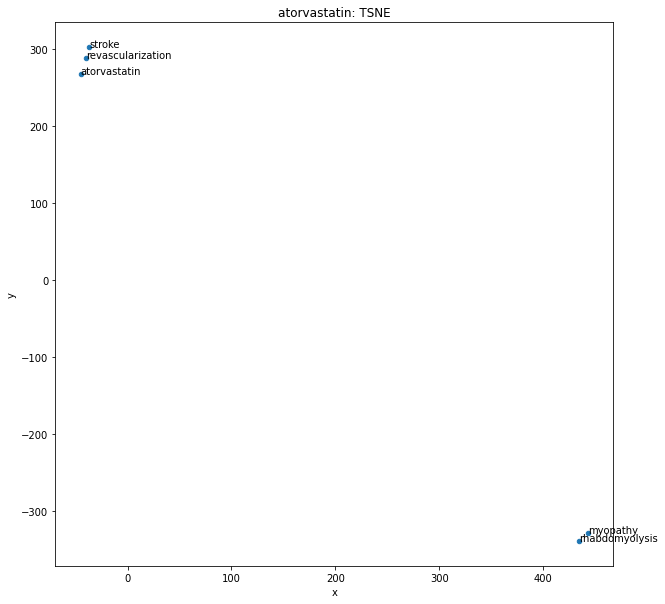

In [10]:
plot_insomnia_drugs()

In [11]:
get_similarity_table()

,name (zolpidem),similarity (zolpidem),name (eszopiclone),similarity (eszopiclone),name (zaleplon),similarity (zaleplon),name (trazodone),similarity (trazodone),name (amitriptyline),similarity (amitriptyline),...,name (clonazepam),similarity (clonazepam),name (temazepam),similarity (temazepam),name (triazolam),similarity (triazolam),name (melatonin),similarity (melatonin),name (atorvastatin),similarity (atorvastatin)
0,-zolpidem,0.920687,-zopiclone,0.902447,zaleplone,0.943367,*trazodone,0.956025,amitriptylin,0.959679,...,clonazepame,0.957945,premazepam,0.904411,nazolam,0.900881,melatonine,0.924059,*atorvastatin,0.963377
1,zolpidem-mr,0.911355,zopiclone,0.902225,zopiclone,0.868204,-trazodone,0.905108,amitriptyline's,0.944972,...,meclonazepam,0.940150,oxazepam,0.901140,triazolam's,0.899569,pr-melatonin,0.874650,atorvastatine,0.961868
2,zolpidem's,0.910981,s-zopiclone,0.889498,zopiclon,0.858176,trazodone's,0.896182,butriptyline,0.941445,...,clonazepam's,0.939033,tazepam,0.896064,alprazolam,0.881076,post-melatonin,0.874476,simvastatin/atorvastatin,0.951448
3,zolpidem-ir,0.901161,zopiclon,0.857775,zolpidem,0.851964,mirtazapine,0.884872,amitriptyline-,0.931882,...,-clonazepam,0.937775,clorazepam,0.893713,brotizolam,0.862709,melatonin's,0.873074,simvastatin,0.944500
4,zolpidem5mg,0.894403,armodafinil,0.853582,quazepam,0.833256,mirtazepine,0.876181,-amitriptyline,0.926768,...,klonazepam,0.937473,loazepam,0.885451,estazolam,0.862285,'melatonin,0.864226,atorvastatin-ezetimibe,0.943374
5,zopiclone,0.877061,modafinil/armodafinil,0.851170,lormetazepam,0.831810,sertraline,0.868659,nortriptyline,0.924192,...,clonazepan,0.903497,prazepam,0.884780,zopiclone,0.856125,melatonin.,0.863914,-atorvastatin,0.937429
6,zaleplon,0.851964,zolpidem,0.833793,-zopiclone,0.830344,paroxetine,0.864204,amitriptylline,0.921486,...,fonazepam,0.902974,bromazepam,0.884433,flubromazolam,0.852681,non-melatonin,0.854305,rosuvastatin,0.935055
7,zopiclon,0.848837,zaleplon,0.828971,eszopiclone,0.828971,esmirtazapine,0.860781,amitriptylinoxide,0.918378,...,cloniprazepam,0.901301,nitrazepam,0.879454,adinazolam,0.850725,-melatonin,0.849795,atorvastatin/ezetimibe,0.934463
8,flurazepam,0.847116,modafinil,0.822295,s-zopiclone,0.820933,mertazapine,0.858050,notriptyline,0.912584,...,clorazepam,0.889567,*lorazepam,0.878711,micazolam,0.849621,phytomelatonin,0.849298,atorvastatin-fenofibrate,0.931724
9,alprazolam,0.845884,alprazolam,0.818584,triazolam,0.817812,normirtazapine,0.856938,imipramine,0.912487,...,*lorazepam,0.886047,lormetazepam,0.877140,aprazolam,0.847656,i-melatonin,0.844448,atorvastatin's,0.931512


In [12]:
get_effects_table()

,name (zolpidem),similarity (zolpidem),name (eszopiclone),similarity (eszopiclone),name (zaleplon),similarity (zaleplon),name (trazodone),similarity (trazodone),name (amitriptyline),similarity (amitriptyline),...,name (clonazepam),similarity (clonazepam),name (temazepam),similarity (temazepam),name (triazolam),similarity (triazolam),name (melatonin),similarity (melatonin),name (atorvastatin),similarity (atorvastatin)
0,zolpidem-induced,0.598309,2-effects,0.562770,zaleplon-induced,0.600395,trazodone's,0.611413,amitriptyline-induced,0.653893,...,chlordiazepoxide-induced,0.601985,chlordiazepoxide-induced,0.573152,triazolam's,0.628441,melatonin-induced,0.663698,atorvastatin-induced,0.652703
1,flurazepam-induced,0.580049,gaboxadol,0.562761,2-effects,0.577867,effect,0.599750,amitriptyline's,0.647353,...,effect,0.596794,beta-effects,0.559174,triazolam-induced,0.624518,melatonin's,0.659568,fluvastatin-induced,0.648590
2,flunitrazepam-induced,0.577757,effect,0.560940,zaleplone,0.572273,chlordiazepoxide-induced,0.594877,amitriptyline-evoked,0.618340,...,clonazepam-induced,0.593944,nitrazepam-induced,0.558631,2-effects,0.585415,melatonin-mediated,0.643791,atorvastatin's,0.644155
3,2-effects,0.575021,zaleplon-induced,0.549063,effect,0.548655,trazodone-induced,0.590991,effect,0.615194,...,diazepam,0.584519,diazepam,0.555995,beta-effects,0.582608,melatonin-enhanced,0.642740,rosuvastatin-induced,0.641841
4,zaleplon-induced,0.570152,ph-effects,0.541145,effects.3,0.544082,amitriptyline-induced,0.589306,amitriptylin,0.611795,...,flurazepam-induced,0.576791,oxazepam,0.555567,chlordiazepoxide-induced,0.582400,melatonin-driven,0.629193,simvastatin-induced,0.639468
5,nitrazepam-induced,0.568244,effectsof,0.536321,effectsof,0.542336,amitriptyline's,0.585783,amitriptylinoxide,0.609800,...,anticonvulsant-like,0.572436,oxazepam-induced,0.555134,effect,0.570646,melatonine,0.622296,atorvastatin-mediated,0.634672
6,alpidem,0.566256,effects.3,0.535089,beta-effects,0.537741,effects.5,0.582114,nortriptyline-induced,0.608549,...,effects.5,0.572239,nitrazepam,0.554290,concentration-effects,0.569827,melatonin-dependent,0.619156,simvastatin's,0.633657
7,chlordiazepoxide-induced,0.564695,sabeluzole,0.534909,h-effect,0.536341,fluvoxamine's,0.578494,beta-effects,0.600308,...,nitrazepam-induced,0.567377,fosazepam,0.552725,alpha-effects,0.568629,melatonin-forming,0.611205,pitavastatin-induced,0.632841
8,nefiracetam-induced,0.564092,beta-effects,0.532627,cannabinomimetic,0.535707,buspirone's,0.577412,effects.3,0.592639,...,beta-effects,0.566571,ripazepam,0.550619,flurazepam-induced,0.562952,melatonin-generating,0.598019,pravastatin-induced,0.623996
9,zolpidem's,0.563608,h-effect,0.531092,ph-effects,0.535676,sertraline's,0.574463,desipramine-induced,0.591893,...,zaleplon-induced,0.565930,effect,0.547967,nitrazepam-induced,0.561788,hormones-induced,0.592605,fluvastatin,0.620963


In [ ]:
tmp_df = get_similarity_table(1000)
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/reddit_finetuned_biowordvec_similarity.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  tmp_df.to_csv(f)




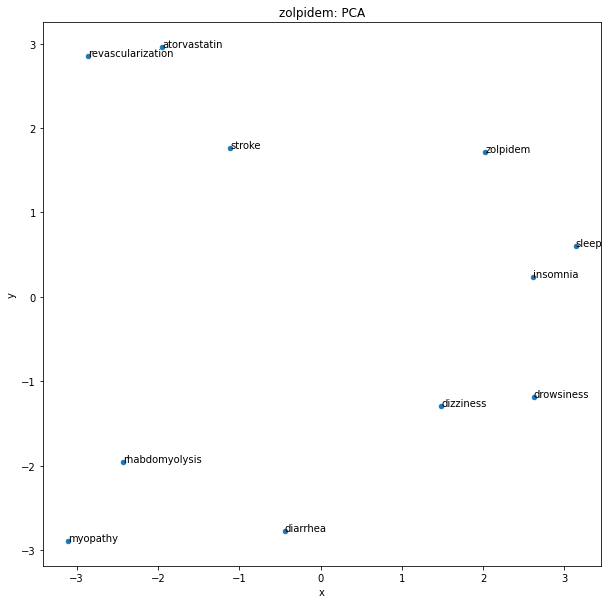

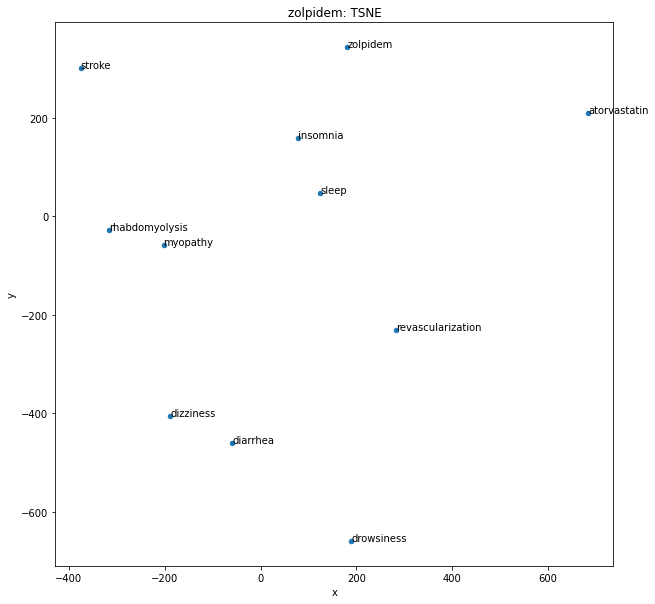

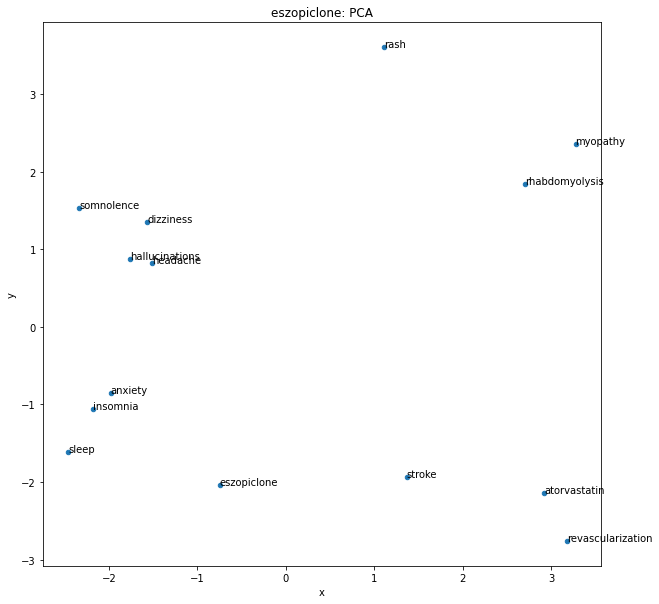

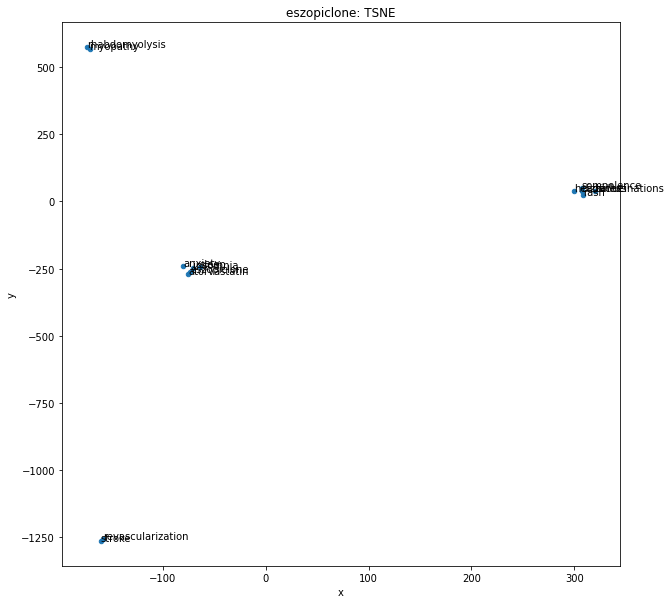

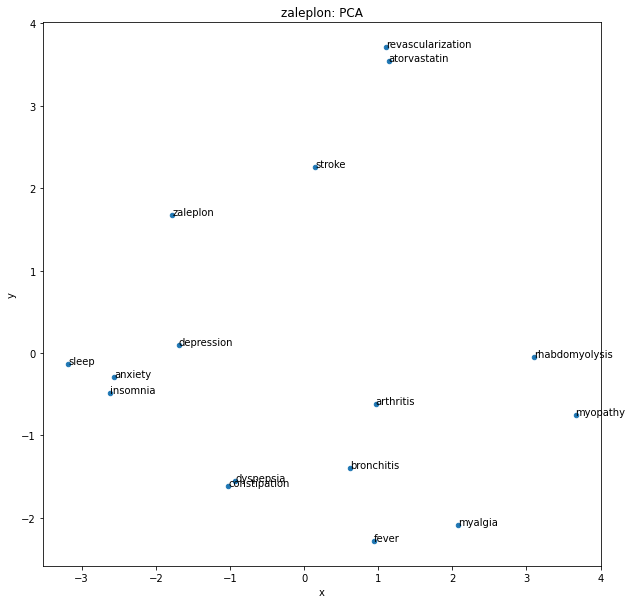

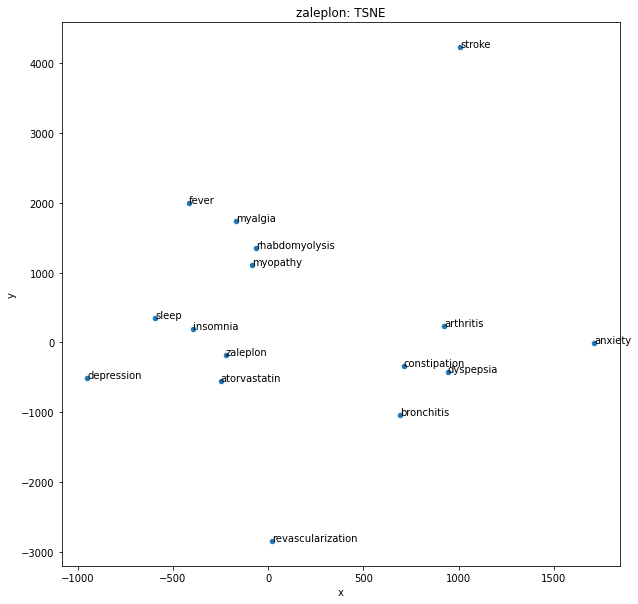

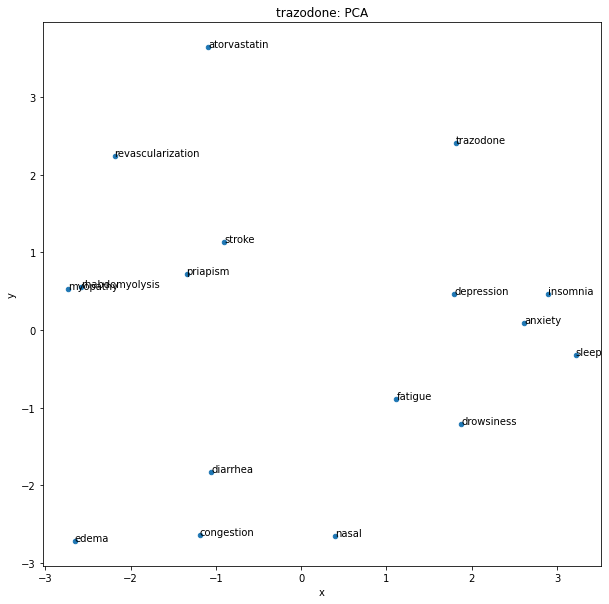

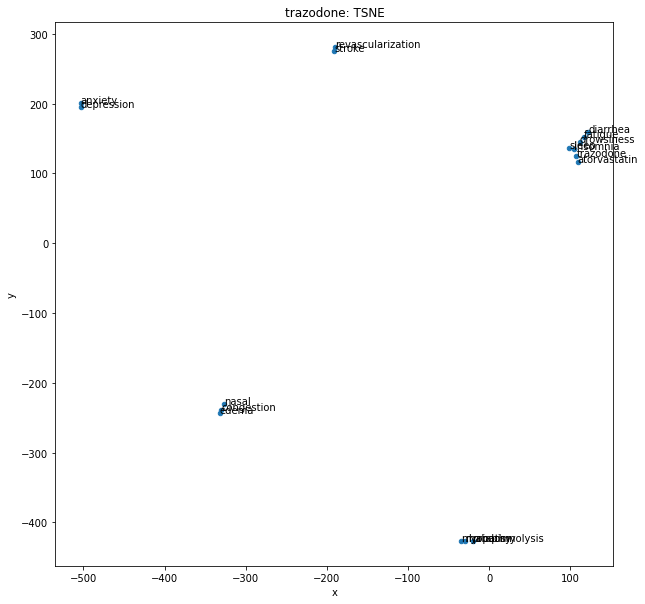

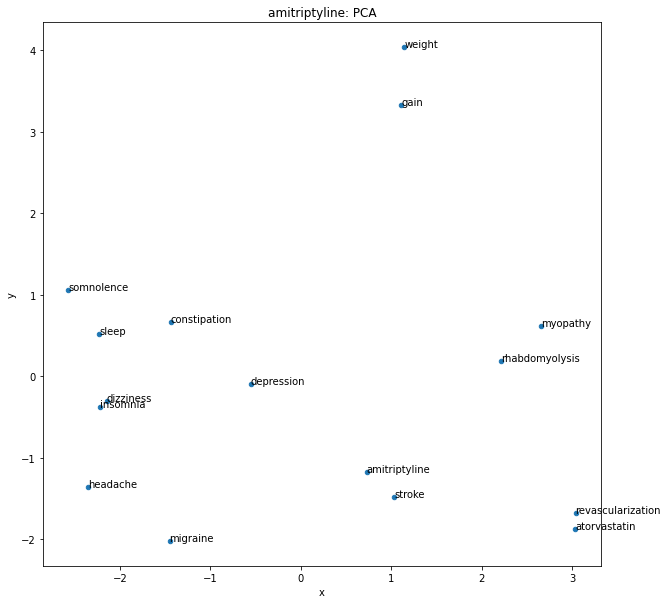

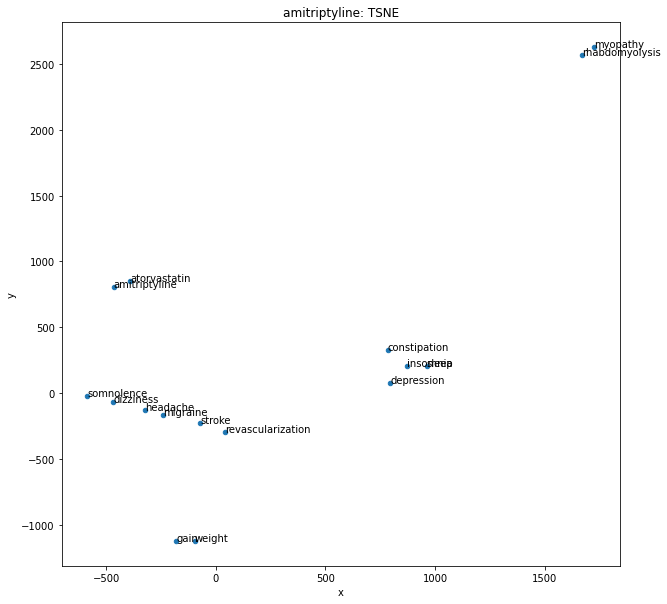

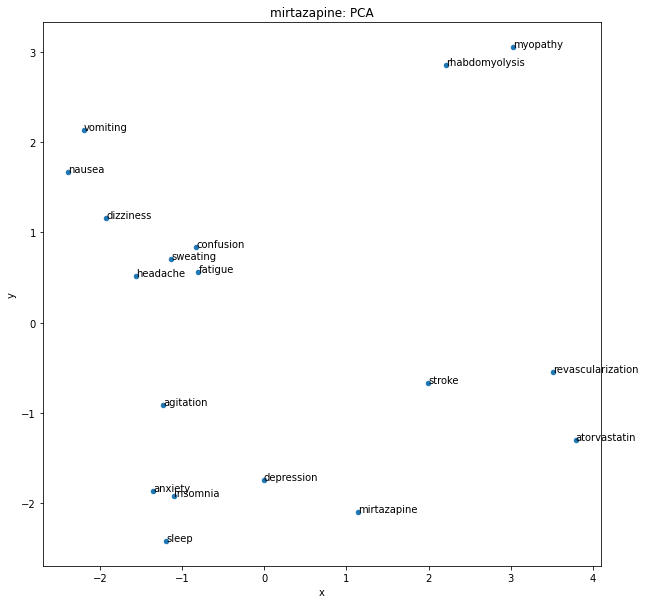

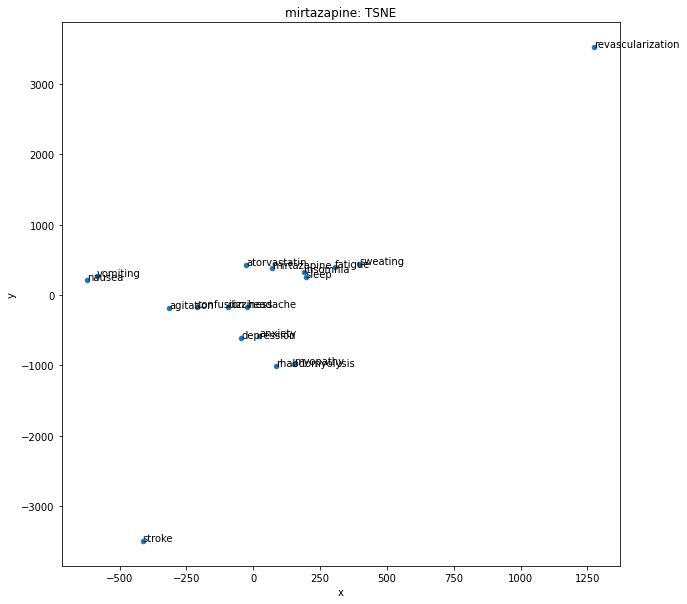

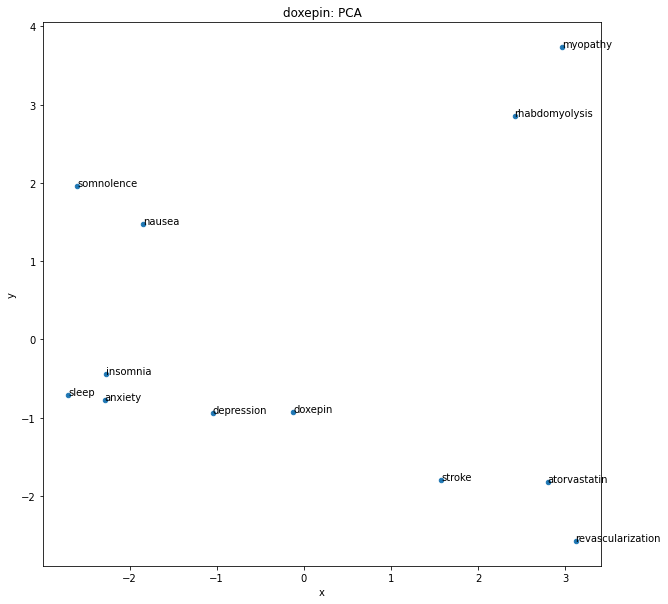

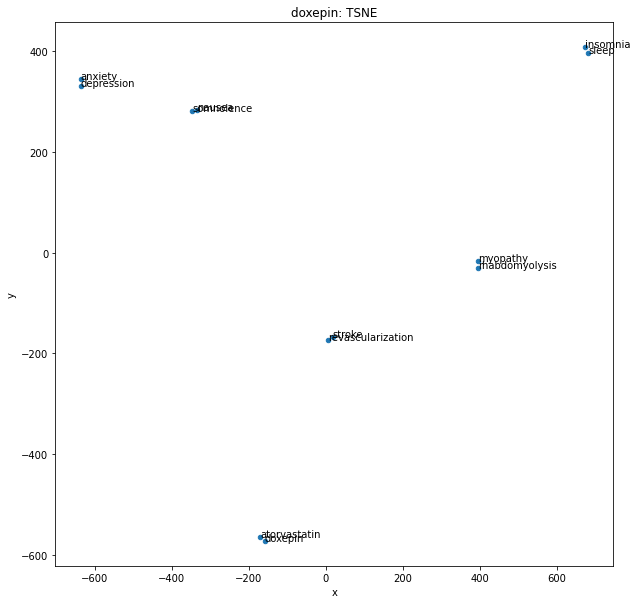

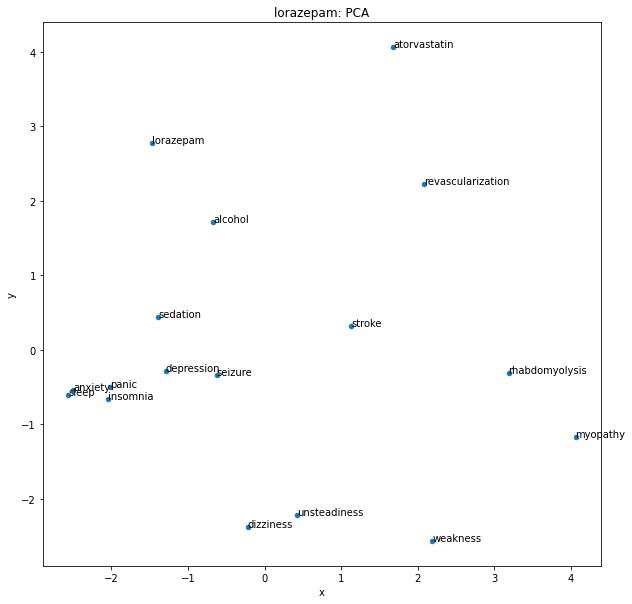

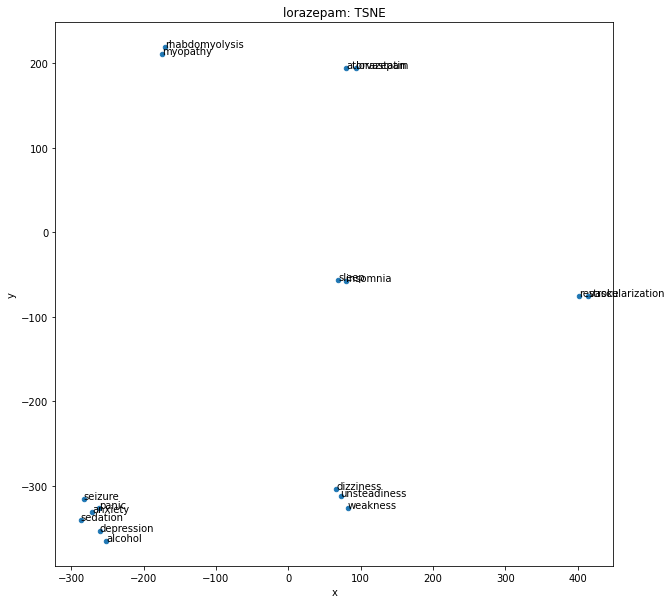

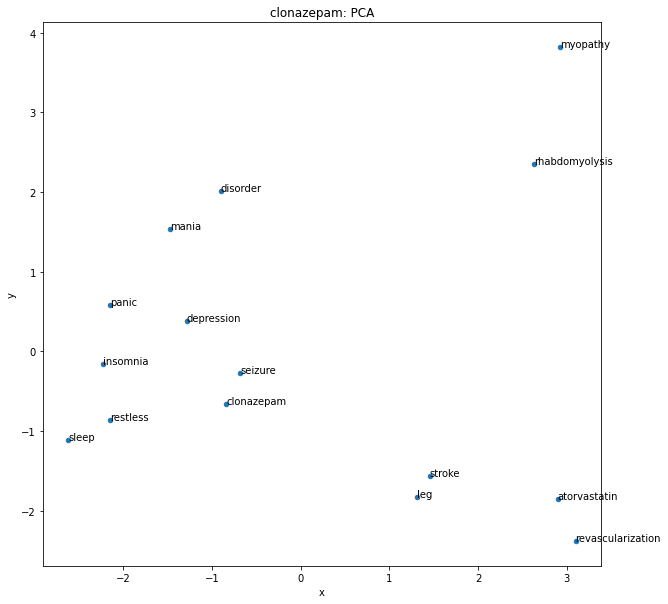

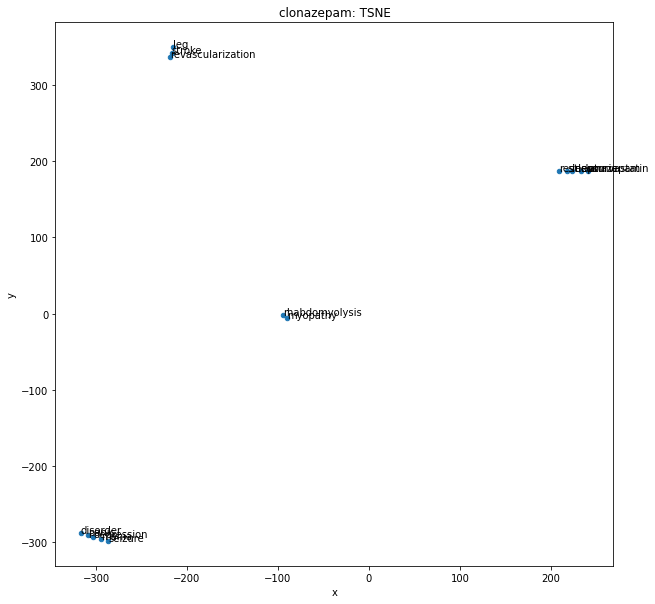

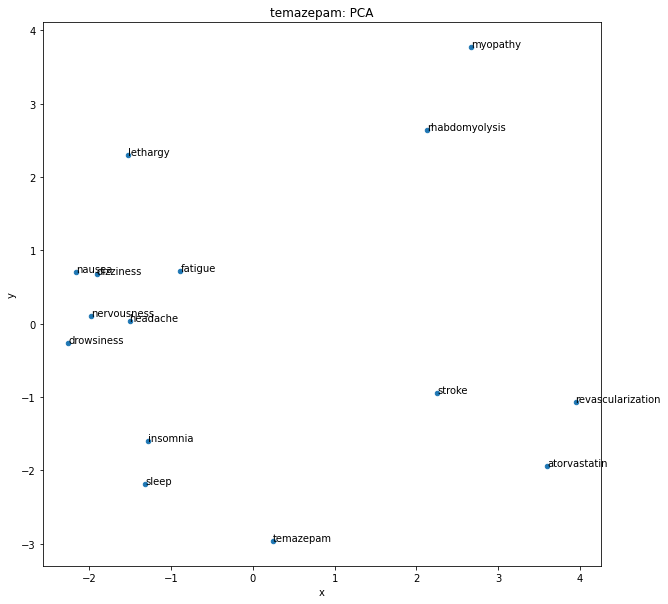

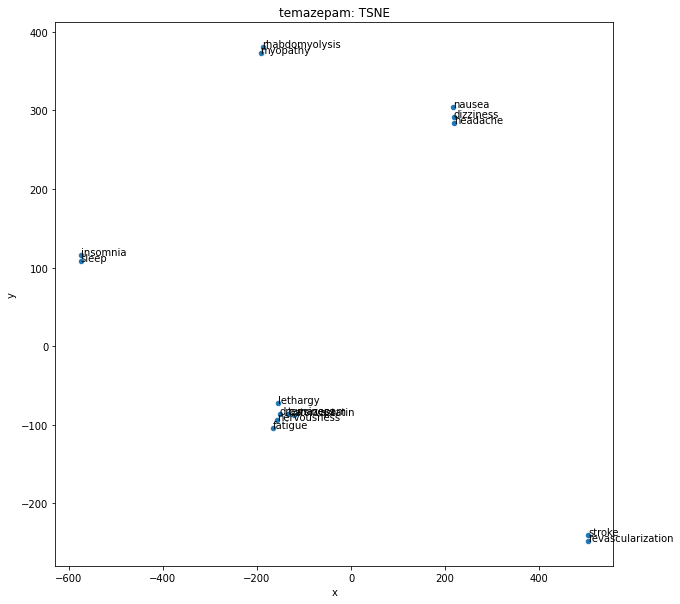

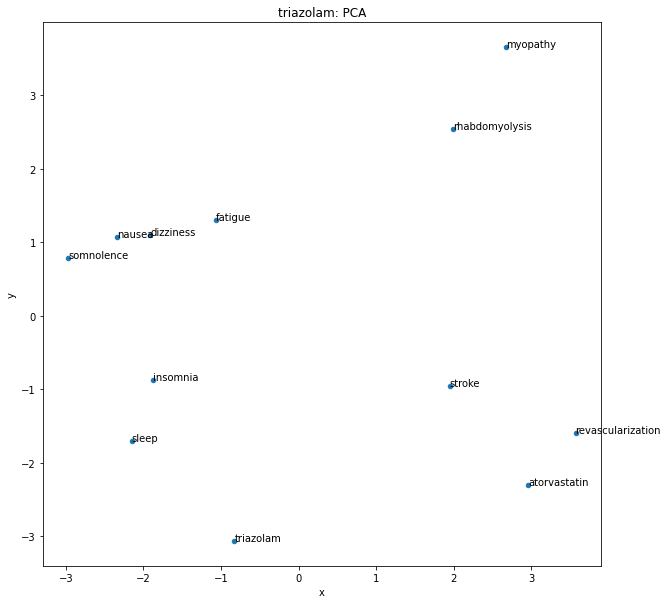

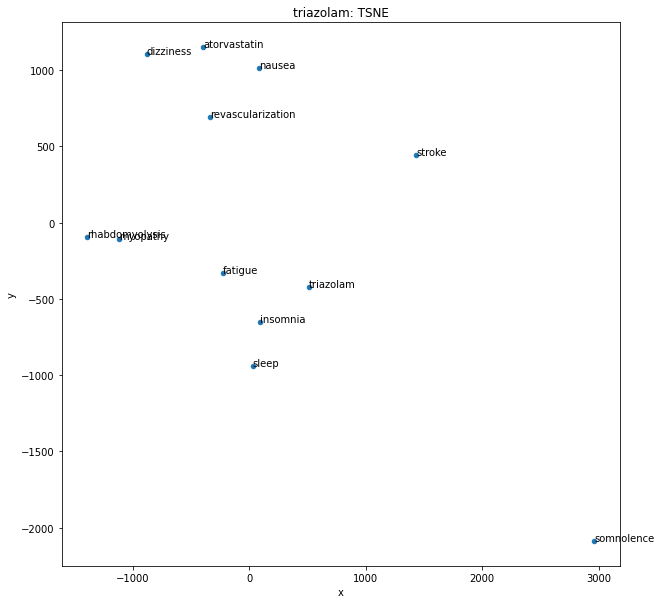

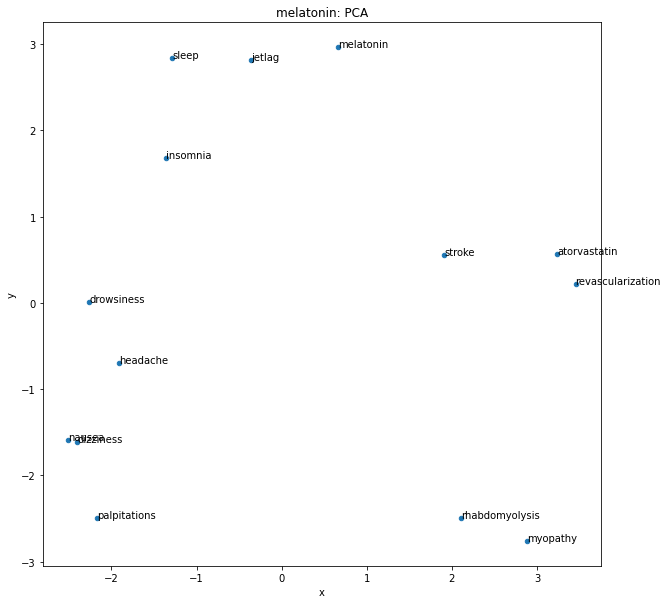

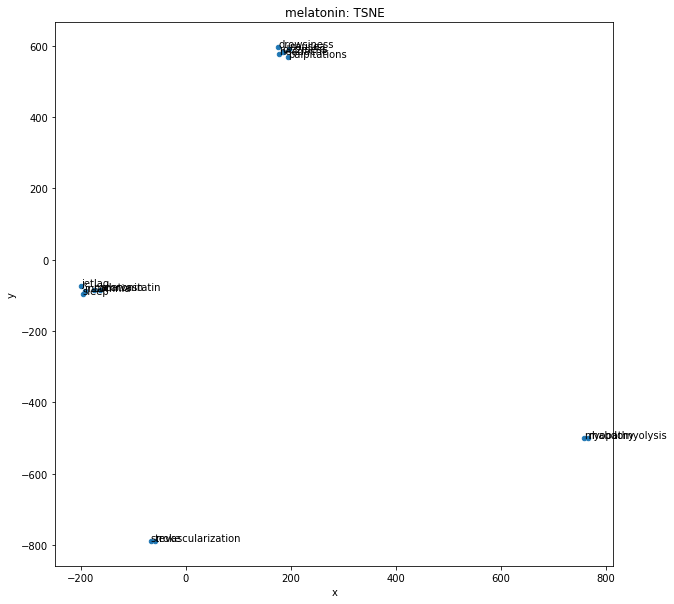

In [13]:
# sensitivity

new_url = "https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects-4.csv"
new_df = pd.read_csv(new_url, header=None, error_bad_lines=False)
insomnia_drug_names2 = new_df[0].tolist()
ind_dct2 = {k: v for v, k in enumerate(insomnia_drug_names2)}

def get_words2(drug_name):
  return [incom for incom in new_df.iloc[ind_dct2[drug_name]] if str(incom) != 'nan']

def plot_with_labels2(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words2(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  title_str = drug_name + (": PCA" if pca else ": TSNE")
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

def plot_insomnia_drugs2():
  for drug in insomnia_drug_names2:
    plot_with_labels2(drug)
    plot_with_labels2(drug, False)

plot_insomnia_drugs2()

0     Text(-2.125305599676706, -0.021582376739308014...
1     Text(-1.3618271753290463, 0.5883204736175813, ...
2     Text(-2.0427269983823653, 1.010866064549647, '...
3     Text(-1.3895076099861319, -0.6553271424145191,...
4     Text(-0.49365997203242806, -0.4915797600830819...
5     Text(-1.0822071507006497, -0.852017587518988, ...
6     Text(-1.0107045483272832, -0.3556155336214189,...
7     Text(-1.9706407126406478, -1.8221726464269645,...
8     Text(-1.8971521708116512, -0.8050153885670889,...
9     Text(-2.0384252721799427, -0.5815017141159743,...
10    Text(-2.200418059771709, 0.7998772966059883, '...
11    Text(0.08060623651156272, 4.381455669508033, '...
12    Text(3.6049490773954926, -0.8600556552468435, ...
13    Text(3.6049490773954926, -0.8600556552468435, ...
14    Text(3.513639020442423, 0.3476626083312876, 'f...
15    Text(3.289169440603401, 0.6678982389885689, 'l...
16    Text(3.519262417490187, -0.4911568916200769, '...
dtype: object

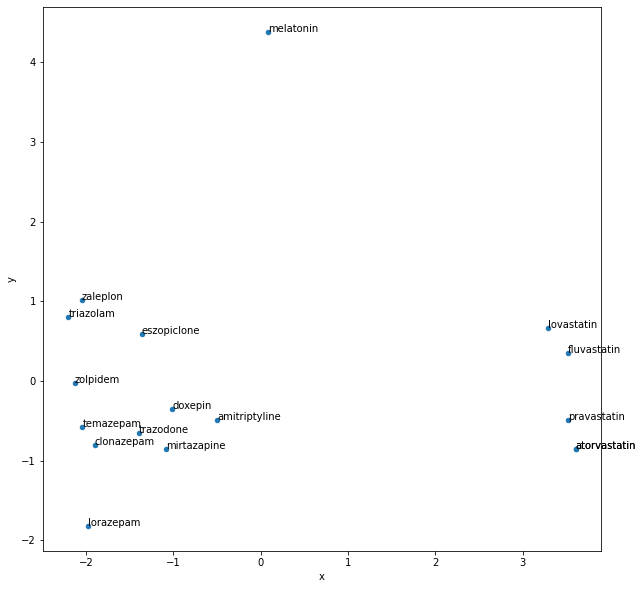

In [14]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_pca(embeddings_lst, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

0     Text(481.763671875, -163.12417602539062, 'zolp...
1     Text(458.9178771972656, -44.16276168823242, 'e...
2     Text(472.678466796875, -115.78118896484375, 'z...
3     Text(-22.718965530395508, -894.0202026367188, ...
4     Text(-499.5952453613281, 279.82257080078125, '...
5     Text(23.733476638793945, -899.4180908203125, '...
6     Text(-465.3173522949219, 313.6988525390625, 'd...
7     Text(-56.327781677246094, -358.2181091308594, ...
8     Text(-77.26818084716797, -400.2164001464844, '...
9     Text(492.5049133300781, 1009.1782836914062, 't...
10    Text(427.82733154296875, 1024.26806640625, 'tr...
11    Text(-550.9306640625, 228.15298461914062, 'mel...
12    Text(794.3045654296875, 320.7042236328125, 'at...
13    Text(840.9556274414062, 317.498046875, 'atorva...
14    Text(-133.9003143310547, 11.442756652832031, '...
15    Text(-69.1058349609375, 44.73695373535156, 'lo...
16    Text(-176.70718383789062, -10.716800689697266,...
dtype: object

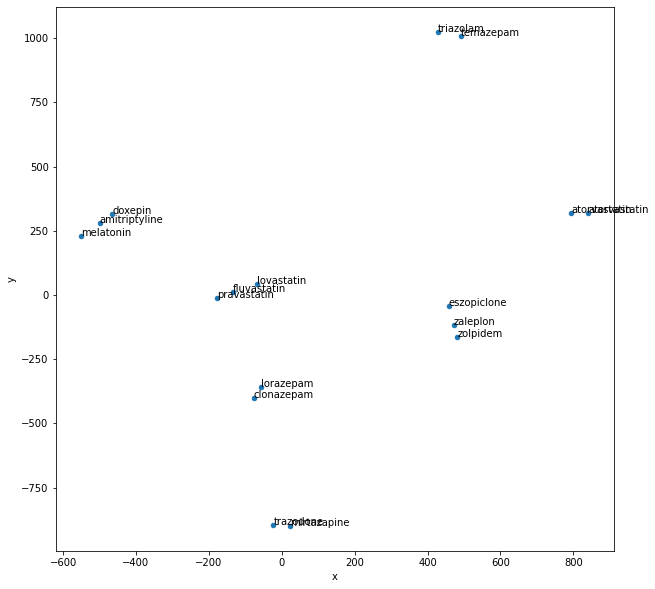

In [15]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

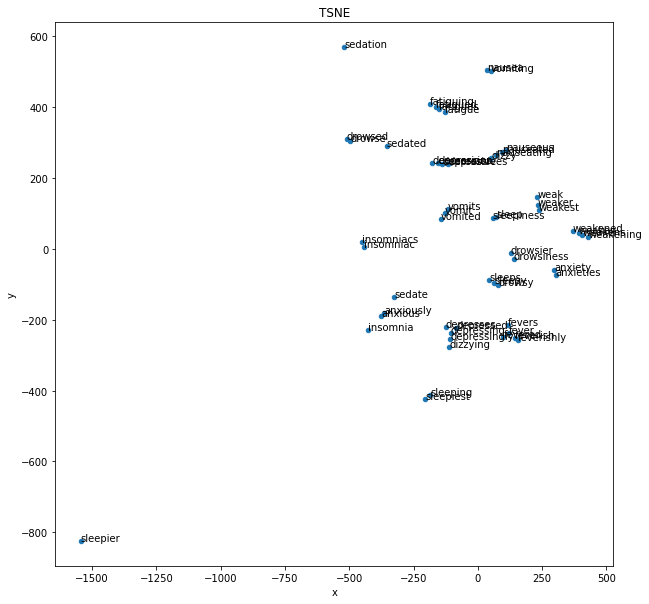

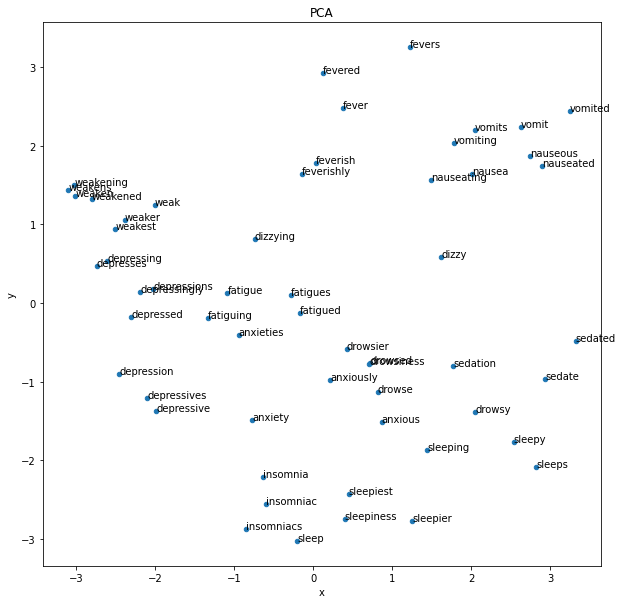

In [16]:
forms_of_words_analysis()